# LibCBM versus CBM-CFS3 growth testing #
This notebook is a automated test of the growth curve implementation in CBM-CFS3 versus that in LibCBM.  The objective is to ensure that LibCBM results match the established CBM-CFS3 model very closely. 

The script automatically generates randomized merchantable volume growth curves in various configurations
 * a random number of merchantable volume curve components, which can result in purely softwood, purely hardwood or mixed stands
 * random spatial unit (which is associated with biomass conversion parameters)
 * one of several random age/volume curve generators with varying amplitudes and start points (impulse, ramp, step, and exp curve)
 
It then compares the results and sorts them by largest different for plotting.

In [1]:
import os, json, math
import numpy as np
import pandas as pd
%matplotlib inline


In [2]:
from libcbm.test import casegeneration
from libcbm.test.cbm3support import cbm3_simulator
from libcbm.test import simulator
from libcbm.test import resultscomparison


variables

In [3]:
age_interval=5
num_age_classes = 40 #required by cbm3
n_steps = 250
cbm3_exe_path = r"M:\CBM Tools and Development\Builds\CBMBuilds\20190530_growth_increment_fix"
toolbox_path = r"C:\Program Files (x86)\Operational-Scale CBM-CFS3"
archive_index_db_path = r"C:\Program Files (x86)\Operational-Scale CBM-CFS3\Admin\DBs\ArchiveIndex_Beta_Install.mdb"

cbm_defaults_db_path = 'C:\dev\cbm_defaults\cbm_defaults.db'
libcbm_path = r'C:\dev\LibCBM\LibCBM\x64\Debug\LibCBM.dll'

generate random cases

In [4]:
cases = casegeneration.generate_scenarios(
    random_seed = 2,
    num_cases = 1,
    dbpath = cbm_defaults_db_path,
    n_steps=n_steps,
    max_disturbances = 0,
    max_components = 1,
    growth_generator = lambda: casegeneration.choose_random_yield_func,
    n_growth_digits = 2,
    age_interval=age_interval,
    max_age=age_interval*num_age_classes)


run test cases on libCBM

In [5]:
libcbm_result = simulator.run_libCBM(libcbm_path, cbm_defaults_db_path, cases, n_steps)


In [6]:
#pools = result["pools"]
#pools[pools["index"]==0].groupby("timestep").sum().plot()

run cases on CBM-CFS3

In [6]:
project_path = cbm3_simulator.import_cbm3_project(
    name="growth_curve_testing",
    cases=cases,
    age_interval=age_interval,
    num_age_classes=num_age_classes,
    nsteps=n_steps,
    cbm_exe_path=cbm3_exe_path,
    toolbox_path=toolbox_path,
    archive_index_db_path=archive_index_db_path)

cbm3_results_path = cbm3_simulator.run_cbm3(
    aidb_path=archive_index_db_path, 
    project_path=project_path,
    toolbox_path=toolbox_path,
    cbm_exe_path=cbm3_exe_path)

cbm3_result = cbm3_simulator.get_cbm3_results(cbm3_results_path)

In [7]:
comparison = resultscomparison.join_pools(libcbm_result["pools"], cbm3_result["pools"])

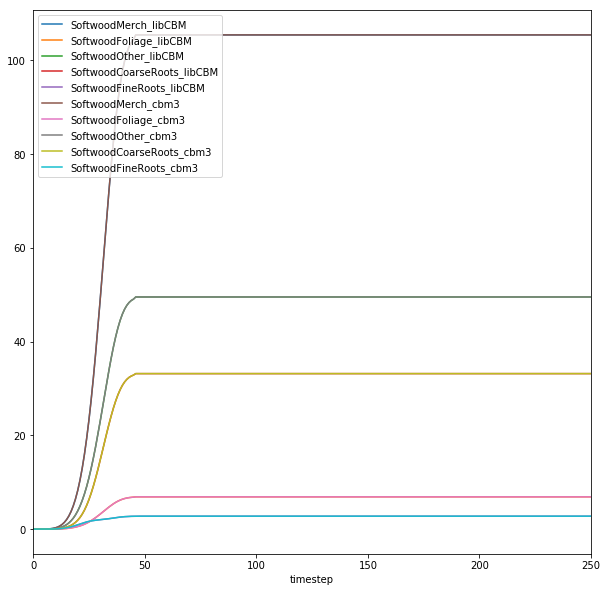

In [15]:
comparison[['timestep',
 'SoftwoodMerch_libCBM',
 'SoftwoodFoliage_libCBM',
 'SoftwoodOther_libCBM',
 'SoftwoodCoarseRoots_libCBM',
 'SoftwoodFineRoots_libCBM',
 'SoftwoodMerch_cbm3',
 'SoftwoodFoliage_cbm3',
 'SoftwoodOther_cbm3',
 'SoftwoodCoarseRoots_cbm3',
 'SoftwoodFineRoots_cbm3']].groupby('timestep').sum().plot(figsize=(10,10))

run test cases on cbm-cfs3. uses [StandardImportToolPlugin](https://github.com/cat-cfs/StandardImportToolPlugin) and [cbm3-python](https://github.com/cat-cfs/cbm3_python) to automate cbm-cfs3 functionality

generate randomized growth curve test cases

In [7]:
cases = generate_cases(random_seed=2, num_curves=500, dbpath=db_path, ndigits=2)

run the test cases on libCBM

In [8]:
libCBM_result = run_libCBM(db_path, cases, n_steps)
libCBM_result["identifier"] = (libCBM_result["index"]+1).apply(get_classifier_name)

run the test cases on cbm-cfs3

In [6]:
cbm3_results_db_path = run_CBM3(cases, age_interval, num_age_classes, n_steps)
cbm3_result = cbm3_results.load_pool_indicators(cbm3_results_db_path, classifier_set_grouping=True)
cbm3_result["age"] = cbm3_result["TimeStep"]

NameError: name 'run_CBM3' is not defined

join the results for plotting

In [7]:

libCBM_biomass = libCBM_result[['identifier','age', 'SoftwoodMerch', 'SoftwoodFoliage', 
               'SoftwoodOther', 'SoftwoodCoarseRoots', 'SoftwoodFineRoots',
               'HardwoodMerch', 'HardwoodFoliage', 'HardwoodOther',
               'HardwoodCoarseRoots', 'HardwoodFineRoots']]

cbm3_biomass = cbm3_result[['identifier','age', 'Softwood Merchantable', 'Softwood Foliage',
             'Softwood Other', 'Softwood Coarse Roots', 'Softwood Fine Roots',
             'Hardwood Merchantable', 'Hardwood Foliage', 'Hardwood Other',
             'Hardwood Coarse Roots', 'Hardwood Fine Roots']]

#make column naming consistent
cbm3_biomass = cbm3_biomass.rename(columns = {
    'Softwood Merchantable': 'SoftwoodMerch',
    'Softwood Foliage': 'SoftwoodFoliage',
    'Softwood Other': 'SoftwoodOther',
    'Softwood Coarse Roots': 'SoftwoodCoarseRoots',
    'Softwood Fine Roots': 'SoftwoodFineRoots',
    'Hardwood Merchantable': 'HardwoodMerch',
    'Hardwood Foliage': 'HardwoodFoliage',
    'Hardwood Other': 'HardwoodOther',
    'Hardwood Coarse Roots': 'HardwoodCoarseRoots',
    'Hardwood Fine Roots': 'HardwoodFineRoots'})

merged = libCBM_biomass.merge(cbm3_biomass,
                              left_on=['identifier','age'],
                              right_on=['identifier','age'],
                              suffixes=("_libCBM","_cbm3"))

diff_colnames = []
cbm3_colnames = []
libCBM_colnames = []
merged["total_diff"]=0
#compute diffs row-by-row
for pool in ['SoftwoodMerch', 'SoftwoodFoliage', 'SoftwoodOther', 'SoftwoodCoarseRoots',
             'SoftwoodFineRoots','HardwoodMerch', 'HardwoodFoliage', 'HardwoodOther',
             'HardwoodCoarseRoots', 'HardwoodFineRoots']:
    
    d = "{}_diff".format(pool)
    l = "{}_libCBM".format(pool)
    r = "{}_cbm3".format(pool)
    diff_colnames.append(d)
    cbm3_colnames.append(r)
    libCBM_colnames.append(l)
    merged[d] = (merged[l] - merged[r])
    merged["total_diff"]+=merged[d]
merged["total_diff"] = merged["total_diff"].abs()

NameError: name 'libCBM_result' is not defined

plot the worst 20 differences

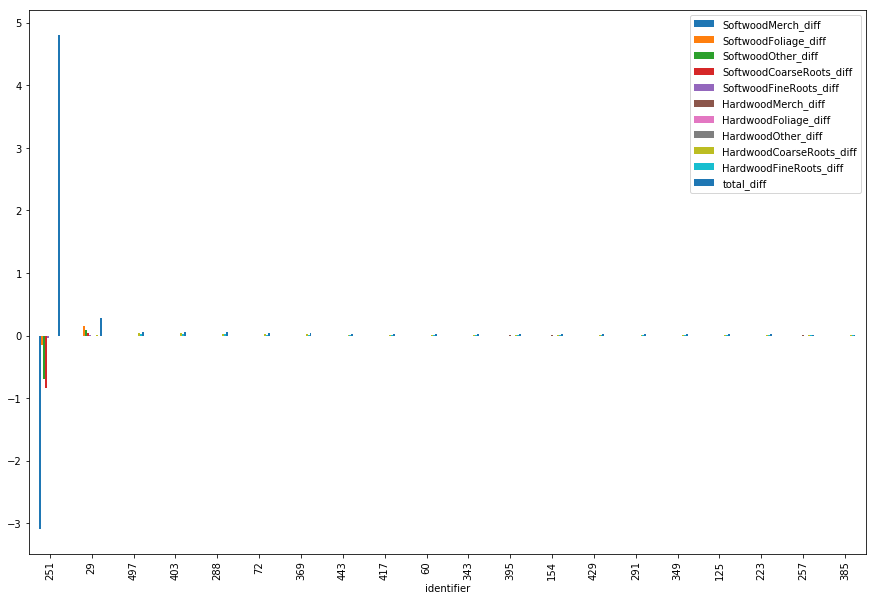

In [11]:
merged[["identifier"]+diff_colnames+["total_diff"]] \
    .groupby("identifier").sum() \
    .sort_values("total_diff", ascending=False) \
    .head(20) \
    .plot(figsize=(15,10), kind="bar")

plot a few of the worst cases for debugging

In [13]:
def plot_diff(id):
    markers = ["o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d"]
    bio_pools = merged[merged["identifier"]==get_classifier_name(id)][["age"]+cbm3_colnames+libCBM_colnames] \
        .groupby("age").sum()
    ax = bio_pools.plot(figsize=(15,20), title=get_classifier_name(id))
    for i, line in enumerate(ax.get_lines()):
        line.set_marker(markers[i%len(markers)])
    ax.legend(ax.get_lines(), bio_pools.columns, loc='best')
    merged[merged["identifier"]==get_classifier_name(id)][["age"]+diff_colnames].groupby("age").sum() \
        .plot(figsize=(15,10), title=get_classifier_name(id))

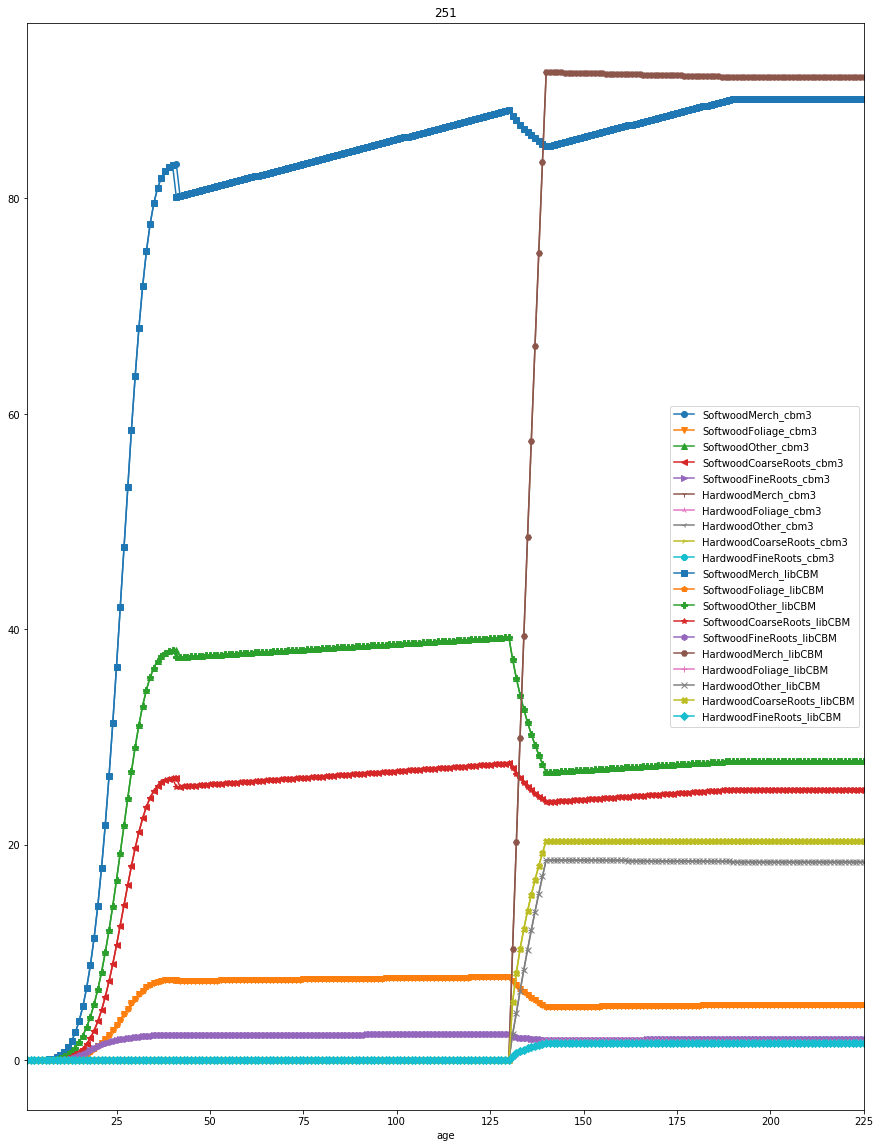

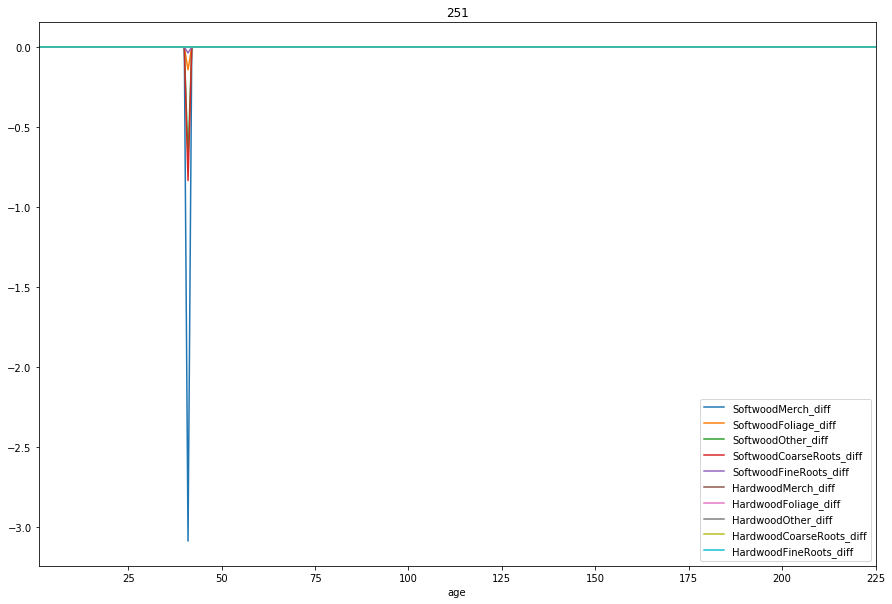

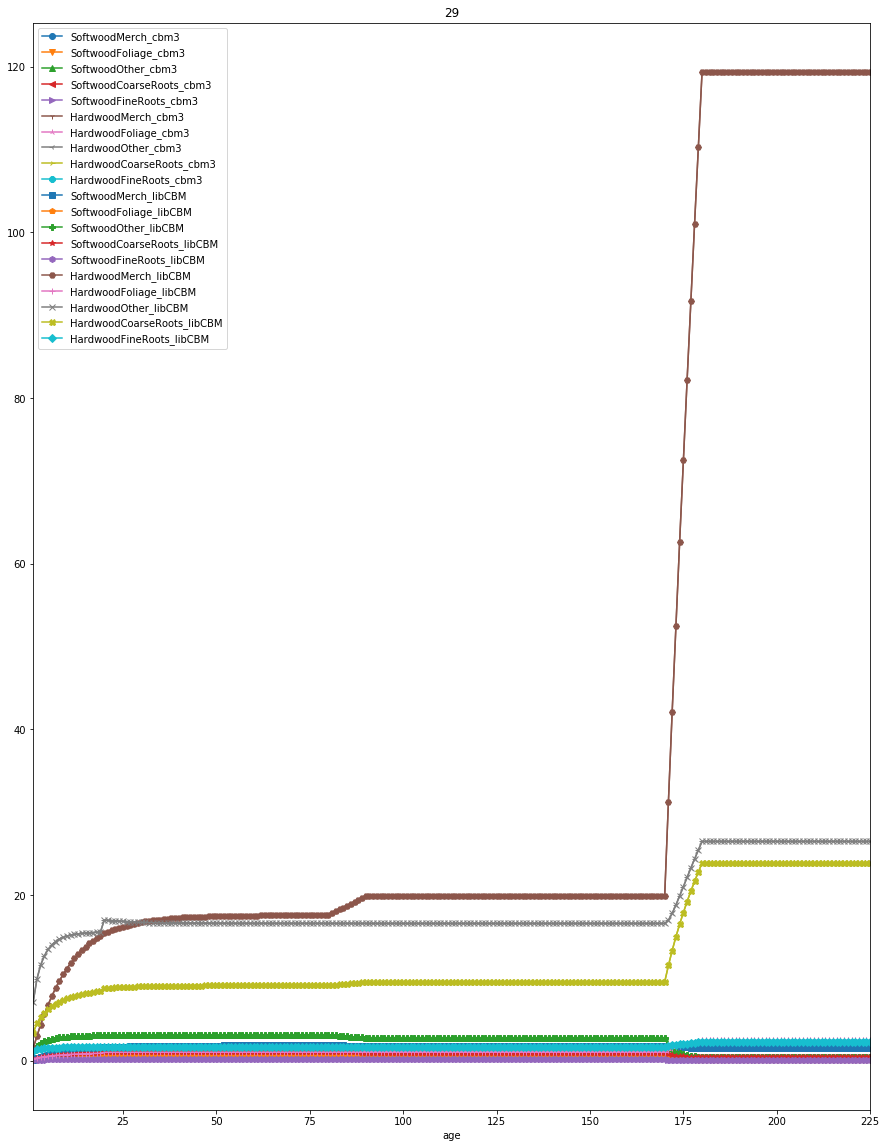

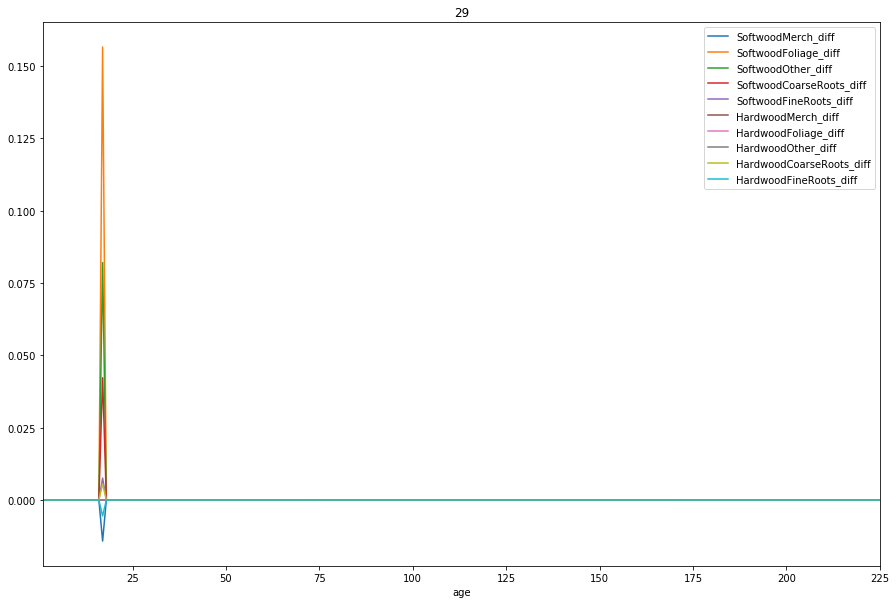

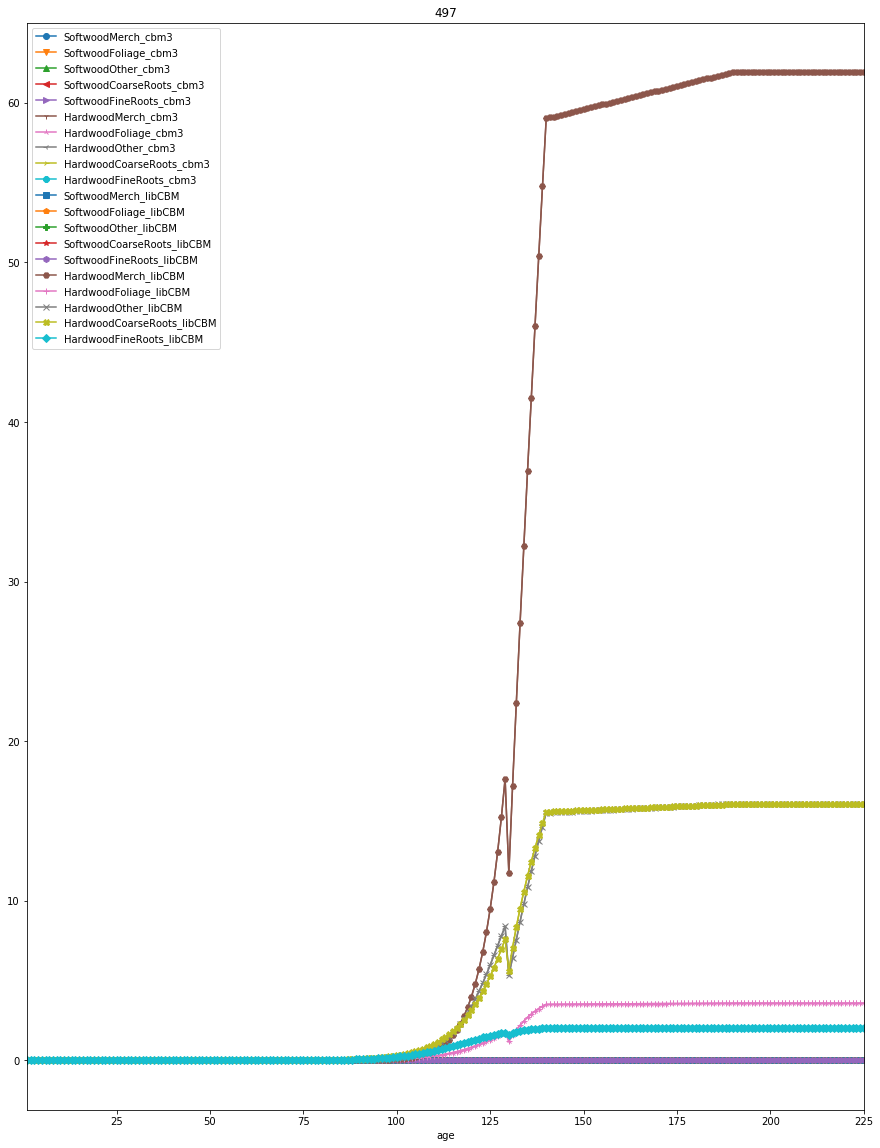

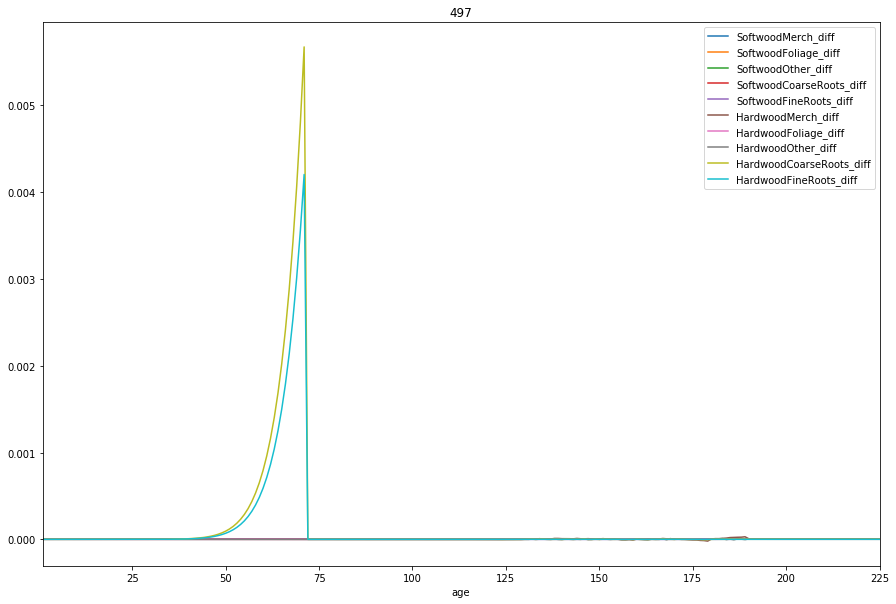

In [16]:
plot_diff(251)
plot_diff(29)
plot_diff(497)

